<a href="https://colab.research.google.com/github/nemoware/suk/blob/master/appeal_outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Appeal outlier detection & experiments

In [1]:
!nvidia-smi

Wed Aug 26 12:12:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [40]:
!pip install tensorflow-gpu
!pip install --upgrade grpcio
!pip install tqdm
!pip install bert-for-tf2
!pip install sentencepiece

from google.colab import output
output.clear()

In [68]:
import os
import math
import datetime


import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# NEW_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
# sns.set_palette(sns.color_palette(NEW_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [67]:
# import tqdm as m_tqdm
from tqdm import tqdm
# # quietly deep-reload tqdm
# import sys
# from IPython.lib import deepreload 

# # stdout = sys.stdout
# # sys.stdout = open('junk','w')
# deepreload.reload(m_tqdm)
# # sys.stdout = stdout

# output.clear()

# m_tqdm.__version__

## Init model

In [69]:
max_seq_len = 512
model_name = "multi_cased_L-12_H-768_A-12"
model_dir = bert.fetch_google_bert_model(model_name, ".models")
model_ckpt = os.path.join(model_dir, "bert_model.ckpt")

classes = ['Трудовое право', 'Интеллектуальная собственность, ИТ, цифровые права', 'Коммерческие операции и поставки', 'Закупки (юридические вопросы)', 'Перевозки и хранение', 'Международные санкции', 'Экологическое право', 'Налоговое право', 'Антимонопольное, тарифное регулирование', 'Строительство, недвижимость и промышленная безопасность', 'Таможенное, валютное регулирование', 'Недропользование (поиск, оценка месторождений УВС, разведка и добыча)']
print(f"classes: {len(classes)}")

Already  fetched:  multi_cased_L-12_H-768_A-12.zip
already unpacked at: .models/multi_cased_L-12_H-768_A-12
classes: 12


In [70]:
# tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

do_lower_case = not (model_name.find("cased") == 0 or model_name.find("multi_cased") == 0)
bert.bert_tokenization.validate_case_matches_checkpoint(do_lower_case, model_ckpt)
vocab_file = os.path.join(model_dir, "vocab.txt")
print(f'Do lower case: {do_lower_case}')
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

Do lower case: False


In [71]:
import params_flow as pf


def create_model(max_seq_len, model_dir, model_ckpt, freeze=True, adapter_size=4):
  bert_params = bert.params_from_pretrained_ckpt(model_dir)
  print(f'bert params: {bert_params}')
  bert_params.adapter_size = adapter_size
  bert_params.adapter_init_scale = 1e-5
  l_bert = bert.BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = l_bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :], name='lambda')(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(name='dense_sin', units=768, activation=tf.math.sin)(cls_out)
  # logits = keras.layers.Dense(name='dense_tanh', units=768, activation="tanh")(cls_out)
  # logits = keras.layers.Dense(name='dense_relu', units=256, activation="relu")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(name='initial_predictions', units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))
  
  model.summary()
  if freeze:
    l_bert.apply_adapter_freeze()
    l_bert.embeddings_layer.trainable=False 
    model.summary()

  # Дополнительная инфа https://arxiv.org/abs/1902.00751
  # apply global regularization on all trainable dense layers
  pf.utils.add_dense_layer_loss(model,
                                kernel_regularizer=keras.regularizers.l2(0.01),
                                bias_regularizer=keras.regularizers.l2(0.01))

  model.compile(optimizer=pf.optimizers.RAdam(),
                # loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])
  
  
  bert.load_stock_weights(l_bert, model_ckpt)
  # bert.load_bert_weights(l_bert, model_ckpt)  

  return model

In [72]:
model = create_model(max_seq_len, model_dir, model_ckpt, adapter_size=6)

bert params: {'initializer_range': 0.02, 'max_position_embeddings': 512, 'hidden_size': 768, 'embedding_size': None, 'project_embeddings_with_bias': True, 'vocab_size': 119547, 'use_token_type': True, 'use_position_embeddings': True, 'token_type_vocab_size': 2, 'hidden_dropout': 0.1, 'extra_tokens_vocab_size': None, 'project_position_embeddings': True, 'mask_zero': False, 'adapter_size': None, 'adapter_activation': 'gelu', 'adapter_init_scale': 0.001, 'num_heads': 12, 'size_per_head': None, 'query_activation': None, 'key_activation': None, 'value_activation': None, 'attention_dropout': 0.1, 'negative_infinity': -10000.0, 'intermediate_size': 3072, 'intermediate_activation': 'gelu', 'num_layers': 12, 'out_layer_ndxs': None, 'shared_layer': False}
bert shape (None, 512, 768)
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 512)]             0     

## Load pretrained weights

In [73]:
model_gdrive_url = 'https://drive.google.com/file/d/1TNXKem6OWWUzPmi5kDahBK0sj0N51o9J/view?usp=sharing'
!gdown --id 1TNXKem6OWWUzPmi5kDahBK0sj0N51o9J --output final.h5 

Downloading...
From: https://drive.google.com/uc?id=1TNXKem6OWWUzPmi5kDahBK0sj0N51o9J
To: /content/final.h5
720MB [00:04, 149MB/s]


In [74]:
model.load_weights('final.h5')

## Classification check

In [75]:
def get_token_ids_old(tokenizer, sentences):
  pred_tokens = map(tokenizer.tokenize, sentences)
  # print(pred_tokens)
  pred_tokens = map(lambda tok: ["[CLS]"] + tok[:min(len(tok), max_seq_len-2)] + ["[SEP]"], pred_tokens)
  pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))
    
  # pad
  pred_token_ids = map(lambda tids: tids +[0]*(max_seq_len-len(tids)),pred_token_ids)
  # pred_token_ids = np.array(list(pred_token_ids))
  pred_token_ids = list(pred_token_ids)
  return pred_token_ids

def get_token_ids_faster(tokenizer, sentences, max_seq_len=512):
  pred_token_ids = []
  for sent in sentences:
    tokens = tokenizer.tokenize(sent)
    tokens = ["[CLS]"] + tokens[:min(len(tokens), max_seq_len-2)] + ["[SEP]"]
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    #pad
    token_ids = token_ids +[0]*(max_seq_len-len(token_ids))
    pred_token_ids.append(token_ids)
  return pred_token_ids

def get_token_ids(tokenizer, sentences):
  return get_token_ids_faster(tokenizer, sentences, max_seq_len = max_seq_len)


In [76]:

sentences = [
  "Требуется определить порядок возмещения вреда почве в случае выявления разливов нефти при првоедении очередной плановой проверки РПН, Акт составлен, предписание выдано. Не обжаловано",
  "На основании ст.193 ТК РФ дисциплинарное взыскание применяется не позднее одного месяца со дня обнаружения проступка. С персональными нарушениями (проступками), когда вина конкретных людей очевидна, все понятно. Точкой отсчета будет считаться документ, фиксирующий событие (Акт нарушения, служебная записка). А что делать с Происшествиями?  Если на объекте случился пожар 01.06.  В течение 15 р.д. ведет работу комиссия по расследованию происшествий (Стандарт компании). В ходе работы комиссии производится разбирательство.  16.06. - результатом работы такой комиссии станет Акт, подписанный всеми членами. Только в этот момент становится понятно, кто персонально виновен.    Какая дата станет днем обнаружения проступка? В принципе, именно в этот момент хотелось бы начинать процесс применения дисциплинарного взыскания. Насколько это законно?   Или 15 р.д. работы комиссии, должны войти в озвученный ранее период в 1 месяц?"
]
pred_token_ids = get_token_ids(tokenizer, sentences)
print(len(pred_token_ids))
probabilities = model.predict(pred_token_ids)
predictions = probabilities.argmax(axis=-1)
print(predictions)
print(probabilities)
for text, label, probs in zip(sentences, predictions, probabilities):
  print(f"text: {text}\ncategory: {classes[label]} prob: {probs[label]}")

2
[6 0]
[[1.6395214e-04 3.0851868e-04 2.5531088e-04 2.5603137e-04 1.4938371e-05
  8.3893351e-04 9.8743641e-01 5.6991813e-04 7.4329390e-04 2.4216162e-04
  5.1473553e-04 8.6557241e-03]
 [9.9749279e-01 4.9746328e-04 5.7351201e-05 2.5686597e-05 1.2543886e-05
  4.5796023e-05 3.2181377e-04 9.8294241e-04 1.4054994e-04 3.6754279e-04
  6.6283628e-06 4.8897444e-05]]
text: Требуется определить порядок возмещения вреда почве в случае выявления разливов нефти при првоедении очередной плановой проверки РПН, Акт составлен, предписание выдано. Не обжаловано
category: Экологическое право prob: 0.9874364137649536
text: На основании ст.193 ТК РФ дисциплинарное взыскание применяется не позднее одного месяца со дня обнаружения проступка. С персональными нарушениями (проступками), когда вина конкретных людей очевидна, все понятно. Точкой отсчета будет считаться документ, фиксирующий событие (Акт нарушения, служебная записка). А что делать с Происшествиями?  Если на объекте случился пожар 01.06.  В течение 1

# Embeddings model

In [77]:
from tensorflow.keras.models import Model
layer_name = 'lambda'
embedding_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)


pred_token_ids = get_token_ids(tokenizer, sentences)
embeddings = embedding_model.predict(pred_token_ids)
print(embeddings.shape)
print(embeddings)



(2, 768)
[[ 0.05856805  0.23338228  0.6083236  ... -0.83950776 -0.1201422
   0.00347215]
 [-0.12845212  0.07729926  0.51145685 ...  0.1160802  -0.389248
   0.3132612 ]]


# Load & prepare excel

In [78]:
url = 'https://drive.google.com/file/d/1cVO8KUNUwXgpqVxuRMUeCNwpdmd89Dlp/view?usp=sharing' 
!gdown --id 1cVO8KUNUwXgpqVxuRMUeCNwpdmd89Dlp --output offers.xlsx 

Downloading...
From: https://drive.google.com/uc?id=1cVO8KUNUwXgpqVxuRMUeCNwpdmd89Dlp
To: /content/offers.xlsx
11.1MB [00:00, 98.3MB/s]


In [79]:
import pandas as pd

# offers_path = '/content/drive/My Drive/files/nemoware/СЮК/База обращений 2019-2020.xlsx'
offers_path = 'offers.xlsx'

df = pd.read_excel(offers_path, sheet_name=1, index_col='Номер обращения') 
df = df[['Тема', 'Текст обращения']]
# sorting by goal 
df.sort_values('Номер обращения', inplace = True) 


df[df.index.duplicated()]


,Тема,Текст обращения
Номер обращения,,
254,Международные санкции,Включен ли А.В.Дюков в санкционные списки США ...
262,Прочее,Согласно ПП РФ от 29.12.2018 N 1719 с 01.01.2...
263,Перевозки и хранение,"Прошу рассмотреть обращение ООО ""Газпромнефть ..."
283,"Интеллектуальная собственность, ИТ, цифровые п...",Добрый день.Поступил запрос напередачу прав (н...
299,"Интеллектуальная собственность, ИТ, цифровые п...",Прошу проверить/доработать проекты договоров (...
...,...,...
2562,Прочее,"Коллеги, добрый день!Прошу проконсультировать ..."
2570,Прочее,Добрый день!Прошу помочь с созданием формы дог...
2663,Международные санкции,Могут ли требования санкционного законодател...


##Duplicates

In [80]:
# dropping ALL duplicte values 
df.drop_duplicates(subset = 'Текст обращения', keep = False, inplace = True) 

df[df.index.duplicated()]

,Тема,Текст обращения
Номер обращения,,


##Stop phrases

In [81]:
import re
clean_re = re.compile(r"(День\s*Добрый|Спасибо|Уточните|Проконсультируйте|Подскажите|Пожалуйста|Хотели\s+уточнить|Возможно\s+ли|Вопрос\:|Тема\s+сообщения|Добрый\s*день|Здравствуйте|Привет|Уважаемые\s+коллеги|Прошу\s+уточнить|Прошу\s+согласовать|Прошу|Коллеги|Просим\s+Вас)\s*[,\!\.\:]?", re.IGNORECASE)


for i, row in tqdm(df.iterrows(), total=df.shape[0]):
  text = row['Текст обращения']
  text = clean_re.sub(' ', text)
  text = text.strip()
  df.at[i,'Текст обращения'] = text

100%|██████████| 2321/2321 [00:01<00:00, 1701.60it/s]


In [82]:
df.loc[df['Тема'] == '-']

,Тема,Текст обращения
Номер обращения,,


In [83]:
df.loc[df['Текст обращения'].isnull()]

,Тема,Текст обращения
Номер обращения,,


In [84]:
df.loc[df['Текст обращения']=='']

,Тема,Текст обращения
Номер обращения,,
2357,Перевозки и хранение,
2682,Прочее,


In [85]:
df.drop([2357,2682], inplace=True)

In [86]:
# Row: 2102	Закупки (юридические вопросы)	"п.8.1 и п.9.1"
df.drop([2102], inplace=True)	

In [87]:

normal_df = df[df['Тема']!='Прочее']
normal_df = normal_df.groupby("Тема").filter(lambda x: len(x) > 10)
normal_df

,Тема,Текст обращения
Номер обращения,,
238,Трудовое право,На основании ст.193 ТК РФ дисциплинарное взыск...
243,Экологическое право,Требуется определить порядок возмещения вреда ...
252,Трудовое право,помочь с определением значения формулировки пр...
253,Трудовое право,проконсультировать по вопросу графика работы с...
256,Экологическое право,разъяснить порядок расторжения Договора в связ...
...,...,...
2790,Закупки (юридические вопросы),дать консультацию по сложившейся ситуации: ...
2793,Коммерческие операции и поставки,Получили обращение от клиента ЗАО Турборус.меж...
2794,Коммерческие операции и поставки,"Обратился действующий клиент ООО ""ТРИАДА"", ИНН..."


In [88]:
pd.__version__

'1.0.5'

# Embeddings

In [89]:
def get_embeddings(embedding_model, tokenizer, vals):
  token_ids = get_token_ids(tokenizer, vals)
  return embedding_model.predict(token_ids)


In [90]:
%%time
normal_vals = normal_df['Текст обращения'].tolist()
normal_embeddings = get_embeddings(embedding_model, tokenizer, normal_vals)
# normal_token_ids = get_token_ids(tokenizer, normal_vals)
# normal_embeddings = embedding_model.predict(normal_token_ids)
normal_embeddings.shape


CPU times: user 33.6 s, sys: 10 s, total: 43.6 s
Wall time: 3min 52s


# Outlier detection model

## Model

In [91]:
def create_outlier_model(input_dim, encoding_dim = 256, hidden_dim = 128):
  input_layer = keras.layers.Input(shape=(input_dim, ), name='input_embeddings')
  
  encoder = keras.layers.Dense(input_dim, activation=tf.math.sin, activity_regularizer=keras.regularizers.l1(10e-5))(input_layer)
  encoder = keras.layers.BatchNormalization()(encoder)
  # encoder = keras.layers.Dropout(0.5)(encoder)
  encoder = keras.layers.Dense(hidden_dim, activation=tf.math.sin)(encoder)
  # encoder = keras.layers.Dropout(0.5)(encoder)
  encoder = keras.layers.BatchNormalization()(encoder)
  
  
  decoder = keras.layers.Dense(hidden_dim, activation=tf.math.sin)(encoder)
  # decoder = keras.layers.BatchNormalization()(decoder)

  decoder = keras.layers.Dense(encoding_dim, activation=tf.math.sin)(decoder)
  # decoder = keras.layers.Dropout(0.5)(decoder)
  # decoder = keras.layers.BatchNormalization()(decoder)
  decoder = keras.layers.Dense(input_dim, activation=tf.math.sin)(decoder)
  autoencoder = Model(inputs=input_layer, outputs=decoder)
  autoencoder.build(input_shape=(None, input_dim))

  autoencoder.summary()

  mae = keras.losses.MeanAbsoluteError()
  adam = keras.optimizers.Adam(learning_rate=0.0021)
  autoencoder.compile(
              # optimizer=pf.optimizers.RAdam(),
              optimizer=adam,
              loss='mse',
              # loss = mae,
              metrics=['accuracy'])

  return autoencoder

# outlier_model = create_outlier_model(normal_embeddings.shape[1], encoding_dim=700, hidden_dim=128)
outlier_model = create_outlier_model(normal_embeddings.shape[1], encoding_dim=768, hidden_dim=256)


Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_embeddings (InputLayer [(None, 768)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 768)               590592    
_________________________________________________________________
batch_normalization_2 (Batch (None, 768)               3072      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               196864    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 768)             

## Fit

In [92]:
from sklearn.model_selection import train_test_split

# X, T = train_test_split(normal_embeddings, test_size=0.1)
# T.shape

In [93]:
%%time
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard
# from tensorflow_addons.callbacks import TQDMProgressBar 
import datetime

nb_epoch = 1000
batch_size = 256
log_dir = "log/appeal_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = TensorBoard(log_dir=log_dir)

# initialize tqdm callback with default parameters
# tqdm_callback = TQDMProgressBar()

# es = EarlyStopping(monitor='val_acc', patience=10, verbose=1)
es = EarlyStopping(patience=4, 
                   verbose=True,
                        restore_best_weights=True, 
                        monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                                   verbose=1, mode='max', min_lr=0.00001)
chkpt = ModelCheckpoint(filepath=f'best_model_{datetime.datetime.now():%Y-%m-%d}'+'-{epoch:02d}-{val_loss:.2f}.h5', 
                        save_best_only=True, 
                        save_weights_only=True,
                        verbose=1
                        )

history = outlier_model.fit(
                    normal_embeddings, normal_embeddings,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[
                              #  chkpt,
                              reduce_lr, 
                               es,
                               tensorboard_callback, 
                               ])

Epoch 1/1000
6/6 [==============================] - 2s 356ms/step - loss: 0.1944 - accuracy: 0.0304 - val_loss: 0.0988 - val_accuracy: 0.0933
Epoch 2/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.1065 - accuracy: 0.1519 - val_loss: 0.0793 - val_accuracy: 0.1867
Epoch 3/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.0792 - accuracy: 0.2563 - val_loss: 0.0704 - val_accuracy: 0.2133
Epoch 4/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.0662 - accuracy: 0.2993 - val_loss: 0.0671 - val_accuracy: 0.2800
Epoch 5/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.0571 - accuracy: 0.3496 - val_loss: 0.0641 - val_accuracy: 0.2733
Epoch 6/1000
6/6 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.3859
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00041999998502433304.
6/6 [==============================] - 0s 15ms/step - loss: 0.0505 - accuracy: 0.3859 - val_loss: 0.0583 - val_accuracy

In [94]:
import os
import glob
files = glob.glob('best_model_*.h5')
files = sorted(files,key=os.path.getmtime)
for filePath in files[1:]:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

In [95]:
epoch, loss = len(history.history['loss']),history.history['loss'][-1]
print(f"{epoch} : {loss}")

670 : 0.01877724751830101


In [96]:
outlier_model.save_weights(f'outlier_best_model_{datetime.datetime.now():%Y-%m-%d}-{epoch:02d}-{loss:.3f}.h5')

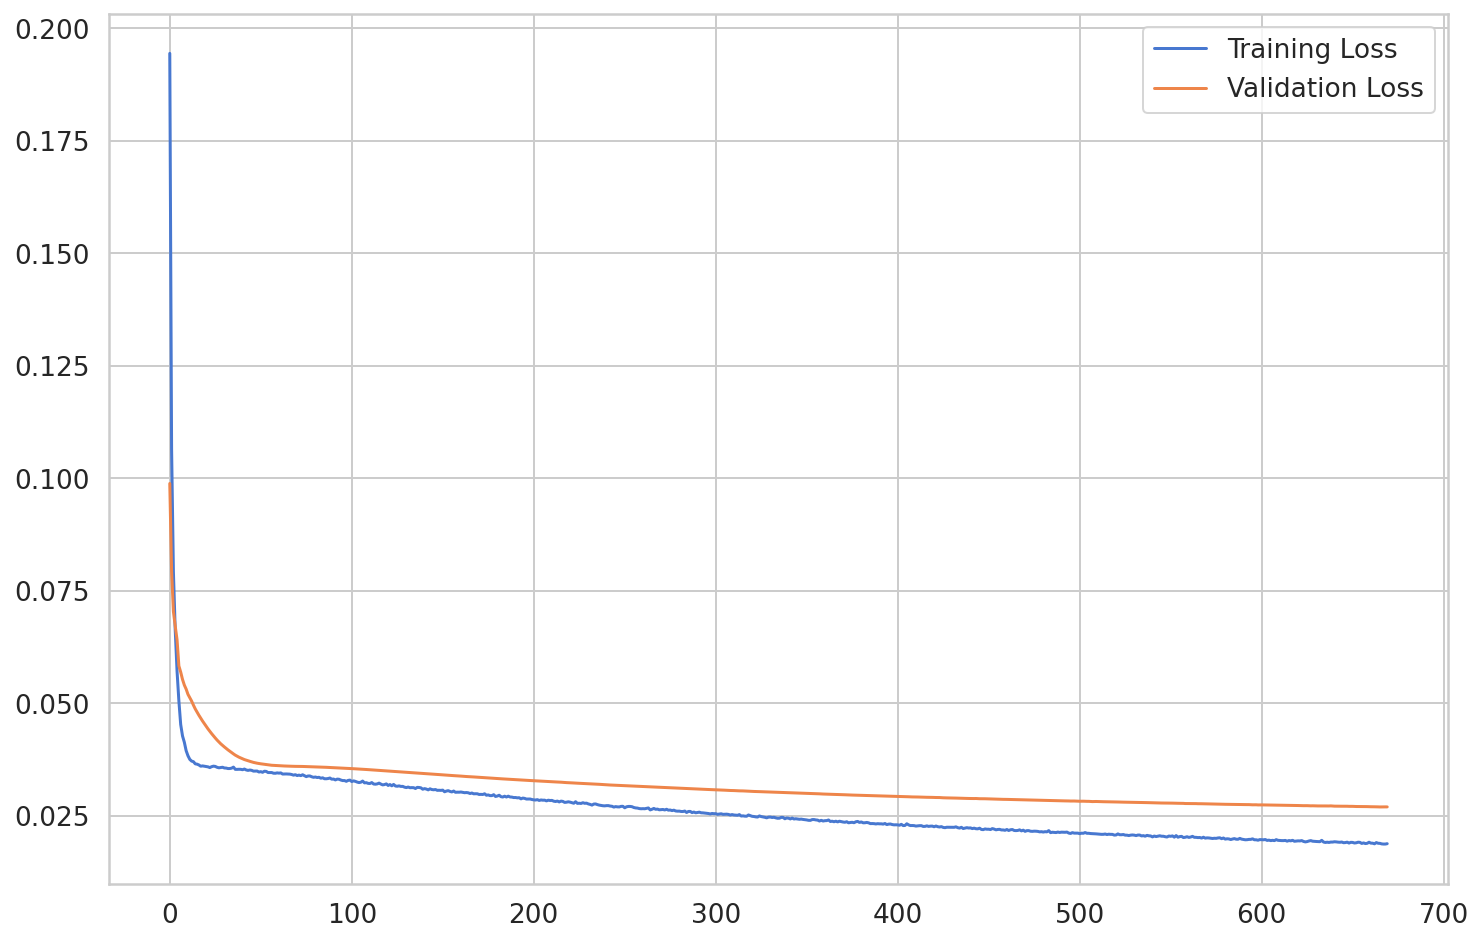

In [97]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

## Train MAE loss

In [98]:
def calculte_reconstruction_error(outlier_model, embeddings):
  embeddings_pred = outlier_model.predict(embeddings)

  mse = np.mean(np.power(embeddings - embeddings_pred, 2), axis=1)
  mae = np.mean(np.abs(embeddings_pred - embeddings), axis=1)
  return (mse, mae) 


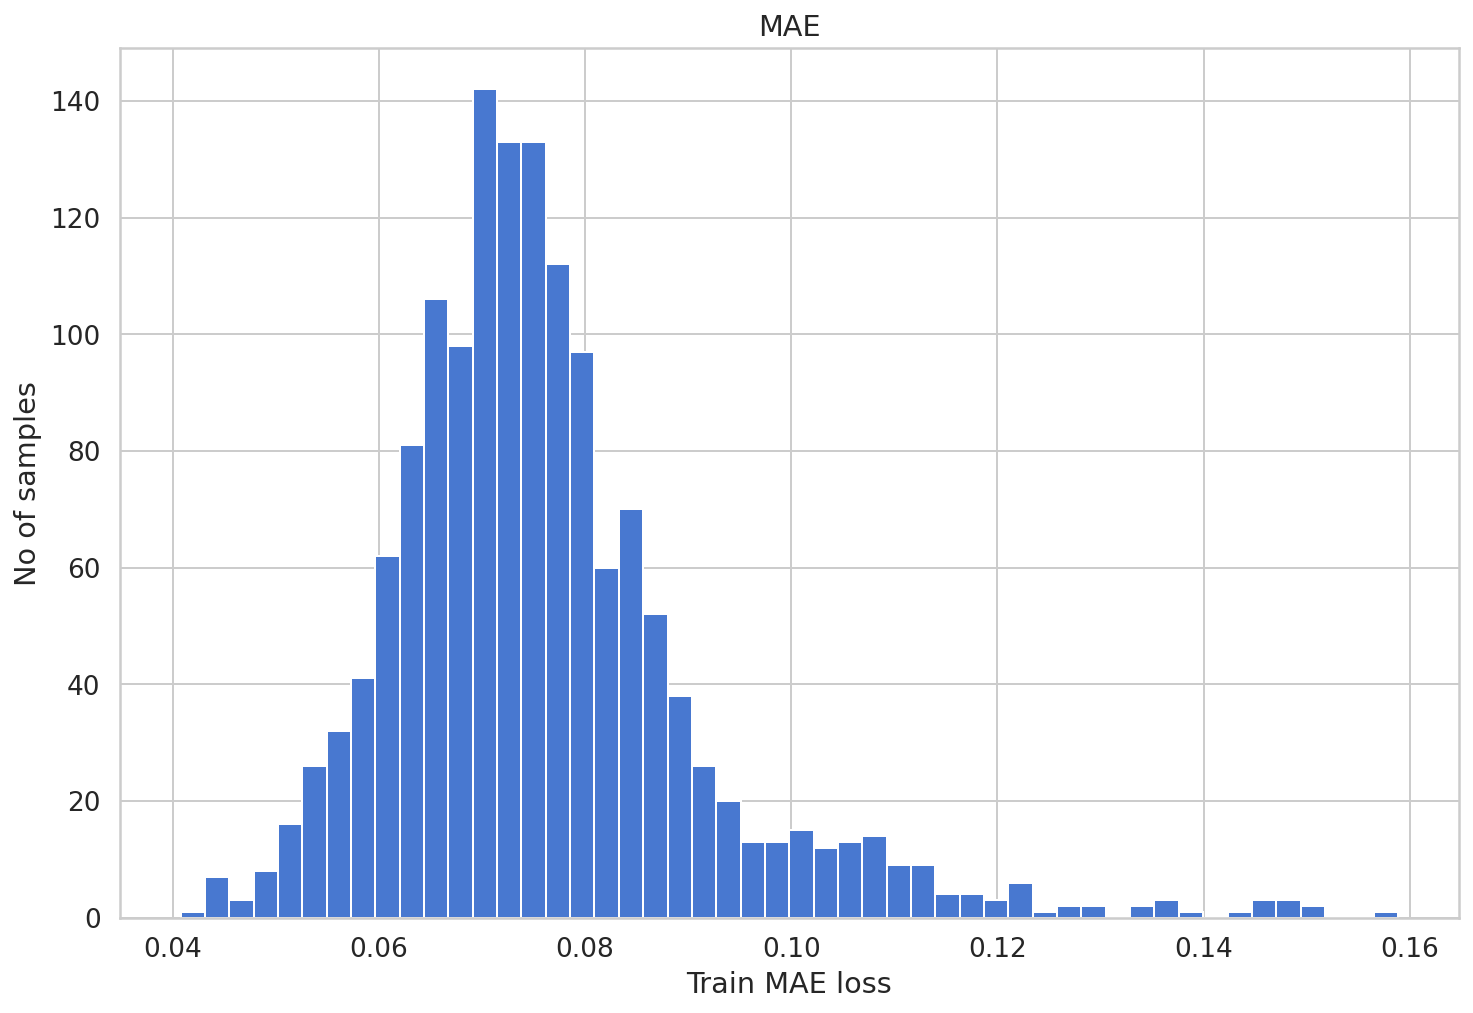

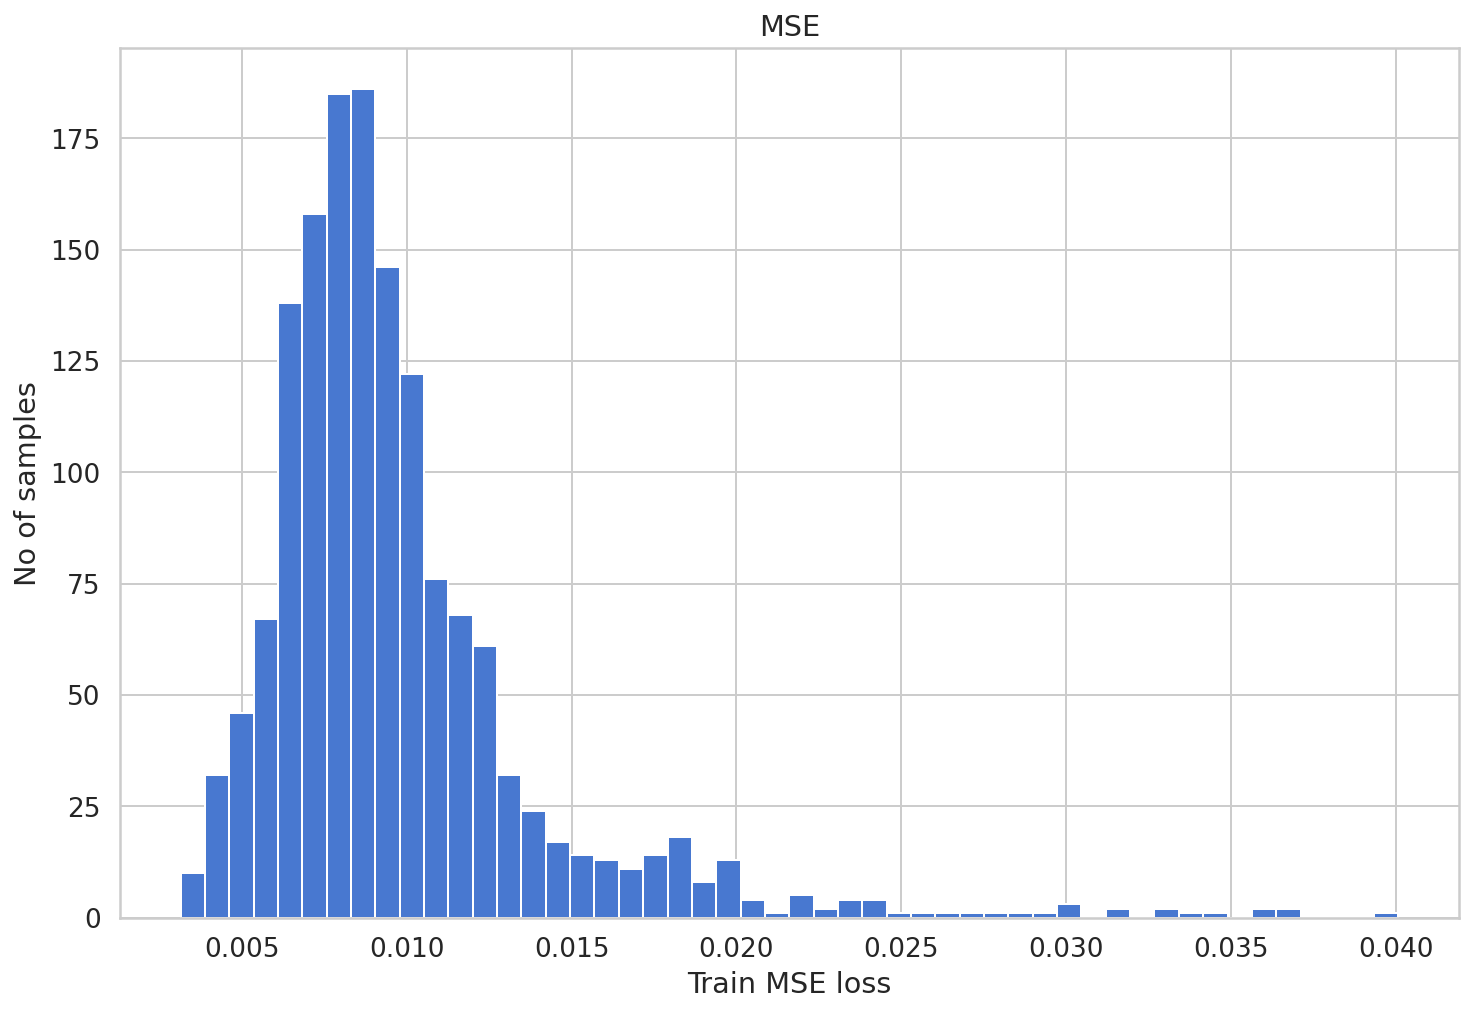

Reconstruction MAE threshold:  0.15886474
Reconstruction MSE threshold:  0.040074673


In [99]:
# Get train MAE loss.
# normal_embeddings_pred = outlier_model.predict(normal_embeddings)
# train_mae_loss = np.mean(np.abs(normal_embeddings_pred - normal_embeddings), axis=1)
# train_mse_loss = np.mean(np.power(normal_embeddings_pred - normal_embeddings, 2), axis=1)

train_mse_loss, train_mae_loss = calculte_reconstruction_error(outlier_model, normal_embeddings)

plt.hist(train_mae_loss, bins=50)
plt.title('MAE')
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(train_mse_loss, bins=50)
plt.title('MSE')
plt.xlabel("Train MSE loss")
plt.ylabel("No of samples")
plt.show()


# Get reconstruction loss threshold.
mae_threshold = np.max(train_mae_loss)
print("Reconstruction MAE threshold: ", mae_threshold)

mse_threshold = np.max(train_mse_loss)
print("Reconstruction MSE threshold: ", mse_threshold)

In [100]:
normal_df['mae'] = train_mae_loss
normal_df['mse'] = train_mse_loss
normal_df

,Тема,Текст обращения,mae,mse
Номер обращения,,,,
238,Трудовое право,На основании ст.193 ТК РФ дисциплинарное взыск...,0.083136,0.011207
243,Экологическое право,Требуется определить порядок возмещения вреда ...,0.109635,0.019410
252,Трудовое право,помочь с определением значения формулировки пр...,0.066429,0.007591
253,Трудовое право,проконсультировать по вопросу графика работы с...,0.051711,0.005193
256,Экологическое право,разъяснить порядок расторжения Договора в связ...,0.079568,0.010247
...,...,...,...,...
2790,Закупки (юридические вопросы),дать консультацию по сложившейся ситуации: ...,0.085898,0.011665
2793,Коммерческие операции и поставки,Получили обращение от клиента ЗАО Турборус.меж...,0.089308,0.013254
2794,Коммерческие операции и поставки,"Обратился действующий клиент ООО ""ТРИАДА"", ИНН...",0.093155,0.014298


In [101]:
x_df = normal_df[normal_df['mse']>0.03]
x_df.head(50)

,Тема,Текст обращения,mae,mse
Номер обращения,,,,
2611,Коммерческие операции и поставки,ВОПРОС ОЧЕНЬ СРОЧНЫЙ!В рамках конкурентного от...,0.151352,0.036956
2622,Перевозки и хранение,Обязательно ли к применению положений Европейс...,0.139639,0.031405
2632,"Строительство, недвижимость и промышленная без...",В связи со сложившейся ситуацией Арендодателю ...,0.146512,0.034357
2640,Трудовое право,Вас провести правовую экспертизу Коллективного...,0.149328,0.035936
2648,Коммерческие операции и поставки,В настоящее время ОНПЗ в рамках проекта по пос...,0.147241,0.033548
2664,Трудовое право,Нужна консультация по проезду в отпуск. Сотруд...,0.145853,0.033128
2686,"Антимонопольное, тарифное регулирование",рассмотреть правки к ДС к дилерскому договору,0.158865,0.040075
2706,Коммерческие операции и поставки,"С ООО ""ИВС-Групп"" (в дальнейшем - Исполнитель)...",0.145481,0.033416
2732,Коммерческие операции и поставки,Может ли ГПН-Хантос в конкретный месяц потребл...,0.151467,0.036898


In [ ]:
x_df['Текст обращения'].tolist()

### Compare reconstruction

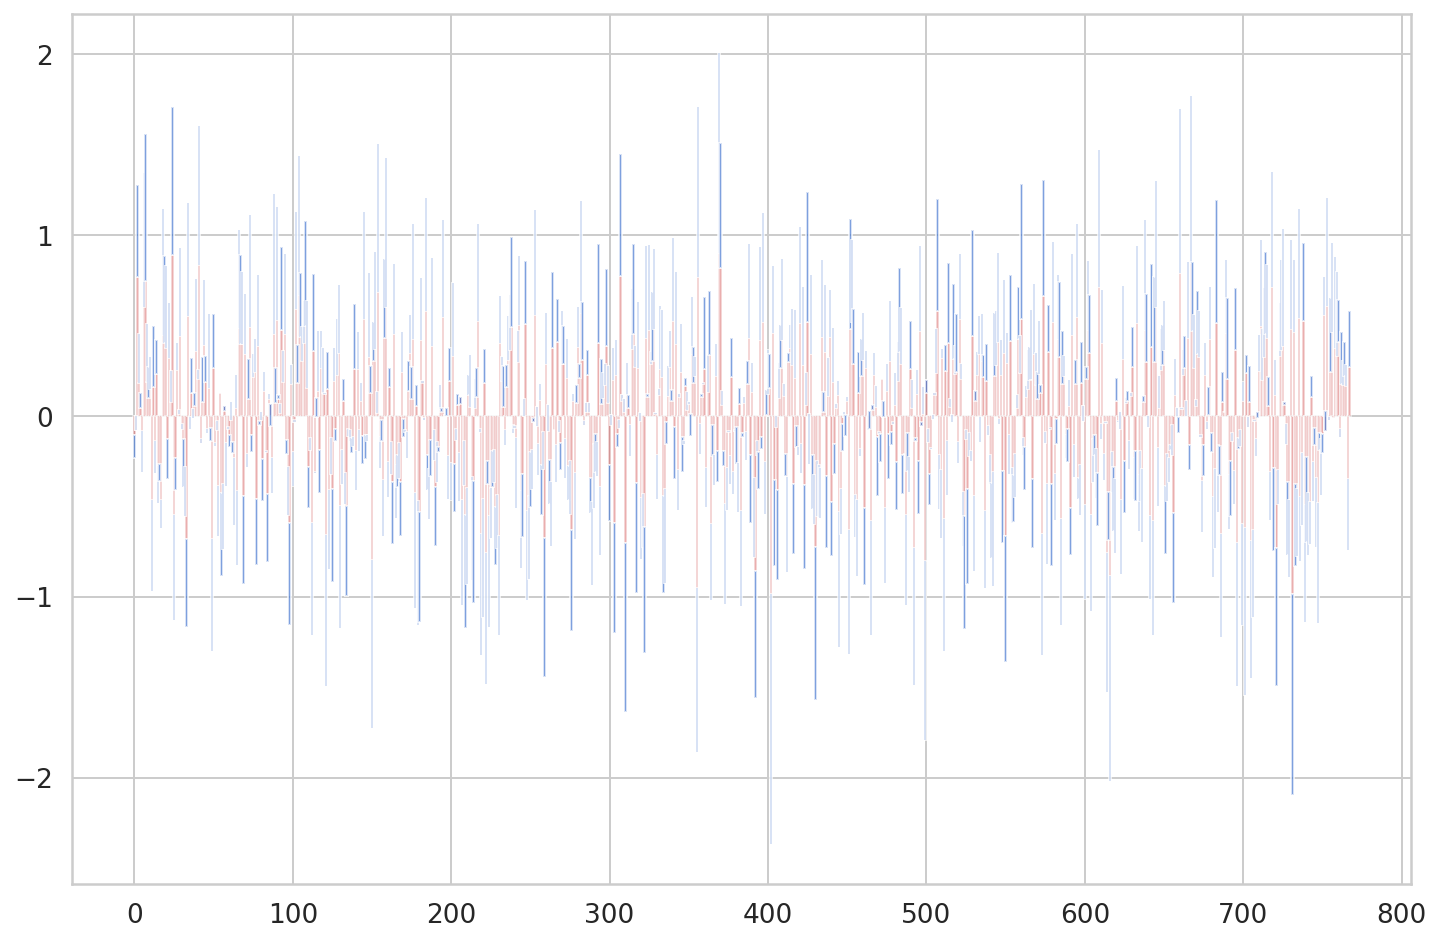

In [105]:
normal_embeddings_pred = outlier_model.predict(normal_embeddings)
ind = np.arange(normal_embeddings.shape[1]) # the x locations for the groups
width = 1.5

plt.bar(ind, normal_embeddings_pred[0], width=width, color='r', alpha=0.5)
plt.bar(ind, normal_embeddings[0], bottom=normal_embeddings_pred[0], width=width, alpha=0.7)

plt.show()

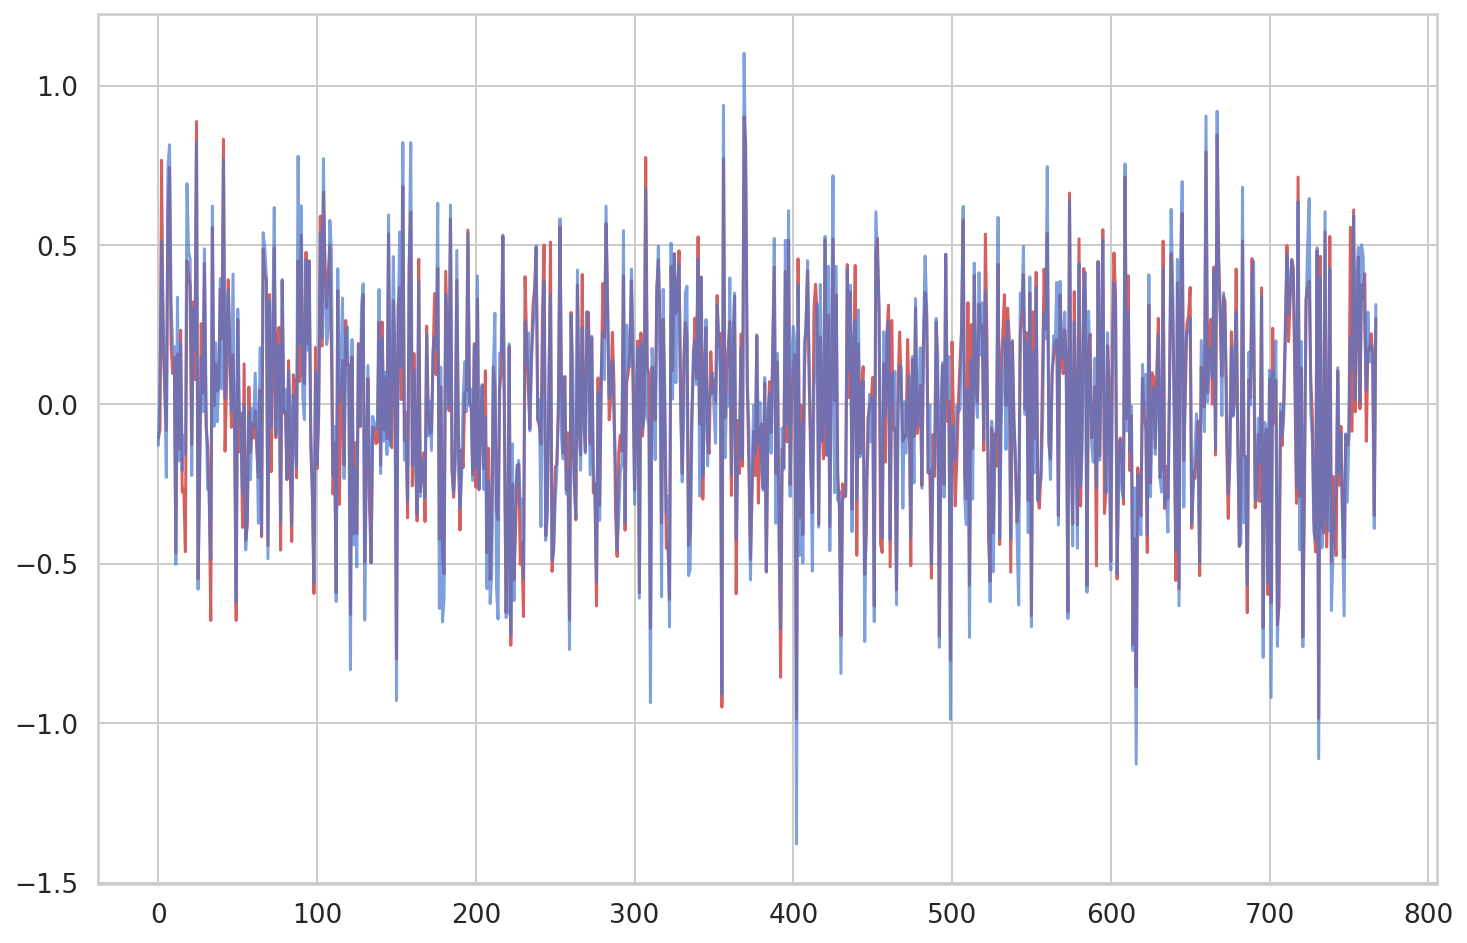

In [106]:
# Checking how the first sequence is learnt


plt.plot(normal_embeddings_pred[0], label="reconstructed", color='r')
# plt.show()
plt.plot(normal_embeddings[0], alpha=0.7)
plt.show()

## Test outliers

In [107]:
outlier_df = df.groupby("Тема").filter(lambda x: len(x) <= 10)
outlier_df

,Тема,Текст обращения
Номер обращения,,
316,Лицензирование недропользования,Общество с ограниченной ответственностью «Техн...
341,Привлечение финансирования и казначейские опер...,Тест
611,Привлечение финансирования и казначейские опер...,вправе ли банк потребовать с организациипогаси...
755,Привлечение финансирования и казначейские опер...,"В настоящий момент АО ""Газпромнефть-ОНПЗ"" нахо..."
809,Привлечение финансирования и казначейские опер...,были ли случаи отказов банков в удовлетворении...
912,Привлечение финансирования и казначейские опер...,СРОЧНО ДД на Программно-аппаратный комплекс...
919,Компетенции органов управления ПАО ГПН,Вцелях определения порядка закупки услуг у доч...
1469,Компетенции органов управления ПАО ГПН,В рамках постоянного государственного надзора ...
1487,Компетенции органов управления ПАО ГПН,Вводная: С целью формирования единых подходов...


In [ ]:
outlier_texts = outlier_df['Текст обращения'].tolist()
outlier_texts

In [109]:
%%time
# outlier_token_ids = get_token_ids(tokenizer, outlier_texts)
# outlier_embeddings = embedding_model.predict(outlier_token_ids)
outlier_embeddings = get_embeddings(embedding_model, tokenizer, outlier_texts)
outlier_embeddings.shape

CPU times: user 540 ms, sys: 111 ms, total: 650 ms
Wall time: 3.22 s


In [110]:
# outlier_embeddings_pred = outlier_model.predict(outlier_embeddings)

# mse = np.mean(np.power(outlier_embeddings - outlier_embeddings_pred, 2), axis=1)
# mae = np.mean(np.abs(outlier_embeddings_pred - outlier_embeddings), axis=1)

mse, mae = calculte_reconstruction_error(outlier_model, outlier_embeddings)

outlier_df['mae'] = mae
outlier_df['mse'] = mse

outlier_df

,Тема,Текст обращения,mae,mse
Номер обращения,,,,
316,Лицензирование недропользования,Общество с ограниченной ответственностью «Техн...,0.141608,0.031479
341,Привлечение финансирования и казначейские опер...,Тест,0.150945,0.036862
611,Привлечение финансирования и казначейские опер...,вправе ли банк потребовать с организациипогаси...,0.129045,0.026467
755,Привлечение финансирования и казначейские опер...,"В настоящий момент АО ""Газпромнефть-ОНПЗ"" нахо...",0.114322,0.021393
809,Привлечение финансирования и казначейские опер...,были ли случаи отказов банков в удовлетворении...,0.132035,0.027191
912,Привлечение финансирования и казначейские опер...,СРОЧНО ДД на Программно-аппаратный комплекс...,0.109896,0.020545
919,Компетенции органов управления ПАО ГПН,Вцелях определения порядка закупки услуг у доч...,0.073220,0.009242
1469,Компетенции органов управления ПАО ГПН,В рамках постоянного государственного надзора ...,0.126583,0.025094
1487,Компетенции органов управления ПАО ГПН,Вводная: С целью формирования единых подходов...,0.073715,0.008351


In [111]:
fixed_mse_threshold = math.trunc(mse_threshold*100.)/100.
fixed_mae_threshold = math.trunc(mae_threshold*100.)/100.
print(f"MAE Threshold: {fixed_mae_threshold} original:{mae_threshold}")
print(f"MSE Threshold: {fixed_mse_threshold} original:{mse_threshold}")

MAE Threshold: 0.15 original:0.15886473655700684
MSE Threshold: 0.04 original:0.040074672549963


In [112]:
fixed_mse_threshold = 0.02

outlier_df['MSE Outlier'] = False
outlier_df.loc[outlier_df['mse']>fixed_mse_threshold, 'MSE Outlier'] = True

outlier_df['MAE Outlier'] = False
outlier_df.loc[outlier_df['mae']>fixed_mae_threshold, 'MAE Outlier'] = True


outlier_df

,Тема,Текст обращения,mae,mse,MSE Outlier,MAE Outlier
Номер обращения,,,,,,
316,Лицензирование недропользования,Общество с ограниченной ответственностью «Техн...,0.141608,0.031479,True,False
341,Привлечение финансирования и казначейские опер...,Тест,0.150945,0.036862,True,True
611,Привлечение финансирования и казначейские опер...,вправе ли банк потребовать с организациипогаси...,0.129045,0.026467,True,False
755,Привлечение финансирования и казначейские опер...,"В настоящий момент АО ""Газпромнефть-ОНПЗ"" нахо...",0.114322,0.021393,True,False
809,Привлечение финансирования и казначейские опер...,были ли случаи отказов банков в удовлетворении...,0.132035,0.027191,True,False
912,Привлечение финансирования и казначейские опер...,СРОЧНО ДД на Программно-аппаратный комплекс...,0.109896,0.020545,True,False
919,Компетенции органов управления ПАО ГПН,Вцелях определения порядка закупки услуг у доч...,0.073220,0.009242,False,False
1469,Компетенции органов управления ПАО ГПН,В рамках постоянного государственного надзора ...,0.126583,0.025094,True,False
1487,Компетенции органов управления ПАО ГПН,Вводная: С целью формирования единых подходов...,0.073715,0.008351,False,False


In [ ]:
outlier_df['Текст обращения'].tolist()

# Outlier Detection VAE

In [ ]:
!pip install alibi-detect

In [ ]:
import logging

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.keras.backend.clear_session()

import alibi_detect
# print(f'alibi_detect: {alibi_detect.od.__all__}')

from alibi_detect.models.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_tabular, plot_roc




n_features = normal_embeddings.shape[1]
latent_dim = 256

encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(n_features,)),
      Dense(700, activation=tf.nn.relu),
      Dense(512, activation=tf.nn.relu),
  ])

decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(latent_dim,)),
      Dense(512, activation=tf.nn.relu),
      Dense(700, activation=tf.nn.relu),
      Dense(n_features, activation=None)
  ])

# initialize outlier detector
od = OutlierVAE(threshold=None,  # threshold for outlier score
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=5)
# train
od.fit(normal_embeddings,
        loss_fn=elbo,
        cov_elbo=dict(sim=.01),
        epochs=30,
        verbose=True)

# save the trained outlier detector
save_detector(od, 'vae_od')


# 'Others' classification

In [ ]:
others_df = df[df['Тема']=='Прочее']
others_df

In [ ]:
others_vals = others_df['Текст обращения'].tolist()
others_vals[:10]

## Predict

In [ ]:
pred_token_ids = get_token_ids(tokenizer, others_vals)



In [ ]:
%%time
probabilities = model.predict(pred_token_ids)
pred_embeddings = embedding_model.predict(pred_token_ids)

In [ ]:
import math
names_col = ['Тема2', 'Тема1']
prob_col = ['Вероятность Темы 2', 'Вероятность Темы 1']
print(len(probabilities))
others_df['Тема1']=''
others_df['Вероятность Темы 1']=0
others_df['Тема2']=''
others_df['Вероятность Темы 2']=0

others_df

In [ ]:
mse, mae = calculte_reconstruction_error(outlier_model, pred_embeddings)

others_df['mae'] = mae
others_df['mse'] = mse

## Set to DataFrame

In [ ]:
print(f'probs len {len(probabilities)}')
print(f'{len(classes)}')

for i in tqdm(range(0, len(probabilities))):
  probs = probabilities[i]
  # print(f'{i} {others_df.iloc[i, 1]}')

  ind = np.argpartition(probs, -2)[-2:] #top-2
  ind = ind[np.argsort(probs[ind])] #sort indices
  # print(ind)

  others_df.iat[i, 2] = classes[ind[0]]
  others_df.iat[i, 3] = round(probs[ind[0]]*100., 1)

  others_df.iat[i, 4] = classes[ind[1]]
  others_df.iat[i, 5] = round(probs[ind[1]]*100., 1)

    # print(f"\tcategory: {classes[j]} prob: {probs[j]*100.:.1f}")



In [ ]:
fixed_mse_threshold = 0.02
fixed_mae_threshold = 0.14

others_df['MSE Outlier'] = False
others_df.loc[others_df['mse']>fixed_mse_threshold, 'MSE Outlier'] = True

others_df['MAE Outlier'] = False
others_df.loc[others_df['mae']>fixed_mae_threshold, 'MAE Outlier'] = True


others_df

In [ ]:

others_df

In [ ]:
others_df.to_excel("predicted.xlsx")  

In [ ]:
# !pip install pyarrow==0.15.1
# !pip install -v perspective-python